# Задание 3: расположение меток/подписей (label placement) 


На входе алгоритма набор пар целочисленных координат точек от 0 до 500, а также для каждой точки размеры подписи к ней (два целых числа — ширина и высота рамки подписи) и некоторое подмножество возможных расположений подписи (см. картинки справа). Кодирование входных данных — на ваш выбор, но лучше согласовать друг с другом в Телеграме, чтобы удобно было обмениваться примерами входных данных. 

На выходе — картинка с точками и неперекрывающимися метками (в частности, не вылезающими за пределы холста 500×500) либо указание, что такое расположение недостижимо. 

Задачу можно решать  

- либо в постановке, когда для каждой точки задан выбор не более чем из двух вариантов расположения подписи, и написать самостоятельно 2-SAT решатель,  

- либо без ограничений на количество вариантов, и тогда допустимо воспользоваться сторонним SAT-решателем, указав, как Вы кодируете задачу.

## Формат данных

Входные данные представлены так
- data.txt - файл, каждая строка которого содержит
  - координата (x,y)
  - значения (ширина, высота) лэйбла
  - координата (x,y) левого нижнего угла лэйбла
  - координата (х,y) правого верхнего угла лэйбла

In [17]:
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

text_file = 'data.txt'

In [18]:
class Pos:
    def __init__(self, *arr):
        assert len(arr) == 2
        self.xy = arr
    
    def __add__(self, that):
        return [a + b for a, b in zip(self.xy, that.xy)]
    
    def __sub__(self, that):
        return [a - b for a, b in zip(self.xy, that.xy)]
    
    def __neg__(self):
        return [-a for a in self.xy]
    
    def __str__(self):
        return str(self.xy)
    
    def __repr__(self):
        return str(self)
    
    def parse(s):
        arr = [int(a) for a in s.split(',')]
        return Pos(*arr)


class Box:
    def __init__(self, line):
        arr = line.split('\t')
        self.pos = Pos.parse(arr[0])
        self.size = Pos.parse(arr[1])
        self.offsets = [Pos.parse(pos) for pos in arr[2].split(' ')]
        assert len(self.offsets) > 0
    
    def __str__(self):
        return 'Box(pos={}, size={}, offsets={})'.format(self.pos, self.size, self.offsets)
    
    def __repr__(self):
        return str(self)


class label_box:
    def __init__(self, line):
        arr = line.split('\t')
        self.offsets = [Pos.parse(pos) for pos in arr[2].split(' ')]
        self.pos = Pos.parse(arr[0])
        self.x = self.pos.xy[0]
        self.y = self.pos.xy[1]
        self.width = Pos.parse(arr[1]).xy[0]
        self.height = Pos.parse(arr[1]).xy[1]

In [19]:
raw_data = open(text_file, 'r').read()

boxes = [Box(line) for line in raw_data.strip().split('\n')]
labels_list = [label_box(line) for line in raw_data.strip().split('\n')]

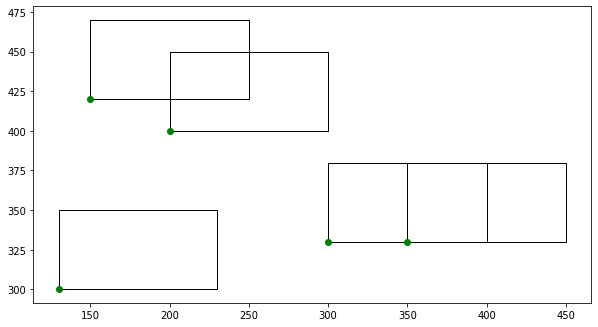

In [20]:
var = 0
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, aspect='equal')

for i in range(len(labels_list)): 
    ax.plot(labels_list[i].x , labels_list[i].y, 'go')
    ax.add_patch(patches.Rectangle((labels_list[i].x + labels_list[i].offsets[0].xy[0], 
                                    labels_list[i].y + labels_list[i].offsets[0].xy[1]),
                               labels_list[i].width, labels_list[i].height, fill=False))

In [21]:
import networkx as nx
N = len(labels_list)
G=nx.DiGraph()

def intersect(label1, label2):
    if (label1.y + label1.height < label2.y) or (label2.y + label2.height < label1.y) or (label1.x + label1.width < label2.x) or (label2.x + label2.width < label1.x):
        return False
    return True

for i in range(N):
    G.add_node(str(i))
    G.add_node("no" + str(i))

cross = []
for i in range(N):
    for k in range(N):
        if i != k and intersect(labels_list[i], labels_list[k]):
            cross.append([i,k])
cross_unique = set()

for elem in cross:
    elem.sort()
    elem_frozen = tuple(elem)
    if (elem[1] - elem[0] == 1) and  (elem[0] // 2 == elem[1] // 2):
        continue
    cross_unique.add(elem_frozen)

for elem in cross_unique:
    node1 = elem[0] // 2
    no_node1 = elem[0] % 2
    node2 = elem[1] // 2
    no_node2 = elem[1] % 2
    if no_node1 == 0 and no_node2 == 0:
        G.add_edge(str(node1), "no" + str(node2))
        G.add_edge(str(node2), "no" + str(node1))
    if no_node1 == 1 and no_node2 == 0:
        G.add_edge("no" + str(node1), "no" + str(node2))
        G.add_edge(str(node2),  str(node1))
    if no_node1 == 1 and no_node2 == 1:
        G.add_edge("no" + str(node1), str(node2))
        G.add_edge("no" + str(node2), str(node1))
    if no_node1 == 0 and no_node2 == 1:
        G.add_edge(str(node1), str(node2))
        G.add_edge("no" + str(node2), "no" + str(node1))

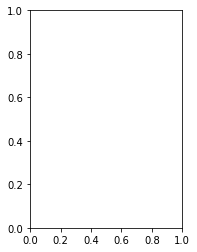

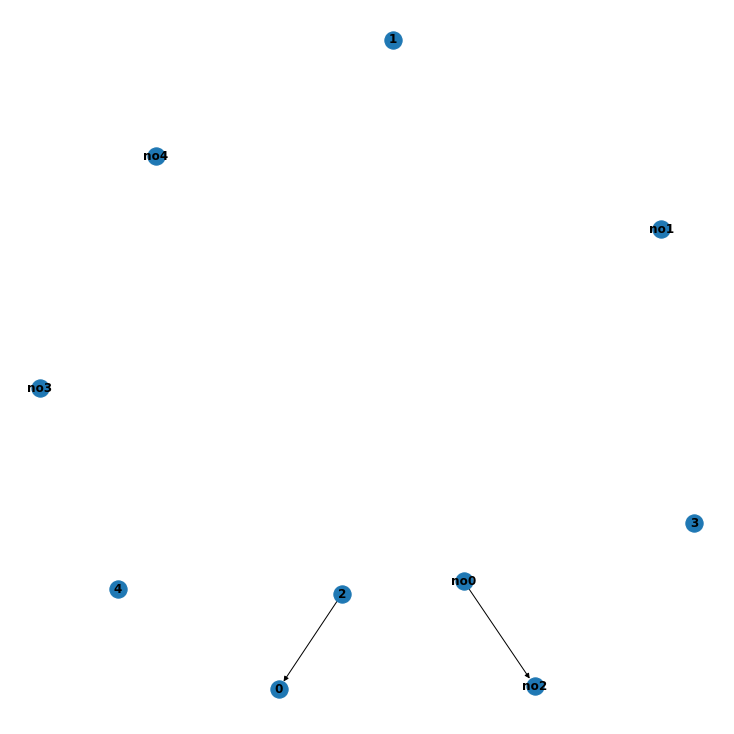

In [22]:
import matplotlib.pyplot as plt

plt.subplot(121)
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, font_weight='bold')

In [23]:
comp = {}
counter = 0
node_var = {}
solution_exists = True
for s in nx.strongly_connected_components(G):
    for node in s:
        comp[node] = counter
    counter += 1
for i in range(N):
    if comp[str(i)] == comp["no" + str(i)]:
        print("no solution")
        solution_exists = False
for i in range(N):
    if comp[str(i)] > comp["no" + str(i)]:
        node_var[i] = 1
    else:
        node_var[i] = 0

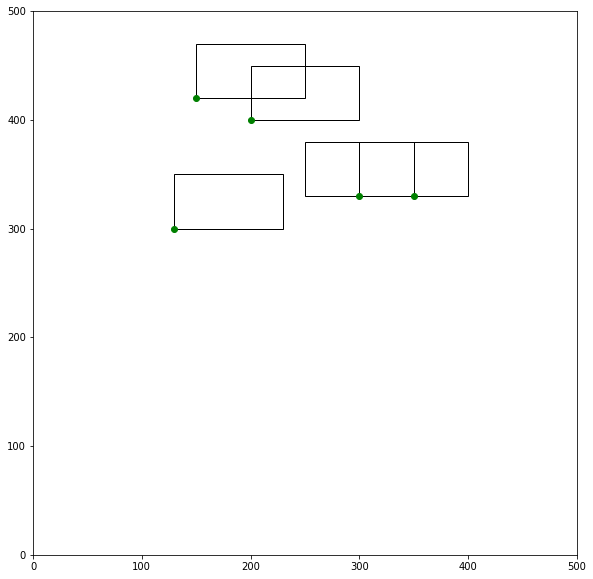

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

if solution_exists:
  fig = plt.figure(figsize = (10,10))
  ax = fig.add_subplot(111, aspect='equal')

  plt.xlim(0, 500)
  plt.ylim(0, 500)

  for i in range(len(labels_list)): 
      ax.plot(labels_list[i].x , labels_list[i].y, 'go')
      ax.add_patch(patches.Rectangle((labels_list[i].x + labels_list[i].offsets[node_var[i]].xy[0], 
                                      labels_list[i].y + labels_list[i].offsets[node_var[i]].xy[1]),
                                 labels_list[i].width, labels_list[i].height, fill=False))
else: print("no solution!")